# Graph Anomaly Detection


## Creating train and test sets

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pickle as pkl

### Load data

In [2]:
# Read files
path = "dades_guillem/"
df_classes = pd.read_csv(path + "elliptic_txs_classes.csv") # Nodes' labels
df_edges = pd.read_csv(path + "elliptic_txs_edgelist.csv") # Edges
df_features = pd.read_csv(path + "elliptic_txs_features.csv", header=None) # Nodes' features

In [3]:
# Change column names of df_features
colNames1 = {'0': 'txId', 1: "Time Step"}
colNames2 = {str(ii+2): "Local_feature_" + str(ii+1) for ii in range(93)}
colNames3 = {str(ii+95): "Aggregate_feature_" + str(ii+1) for ii in range(72)}

colNames = dict(colNames1, **colNames2, **colNames3 )
colNames = {int(jj): item_kk for jj,item_kk in colNames.items()}

df_features = df_features.rename(columns=colNames)

In [4]:
# Pass unknown to number 3. 1 ilicit, 2 licit
df_classes.loc[df_classes['class'] == 'unknown', 'class'] = '3'
print('Shape of classes', df_classes.shape)
print('Shape of edges', df_edges.shape)
print('Shape of features', df_features.shape)

Shape of classes (203769, 2)
Shape of edges (234355, 2)
Shape of features (203769, 167)


### Data visualization

In [5]:
# Merge Class and features
df_class_feature = pd.merge(df_classes, df_features)
df_class_feature.head()

,txId,class,Time Step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,...,Aggregate_feature_63,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72
0,230425980,3,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,3,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,3,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,2,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,3,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


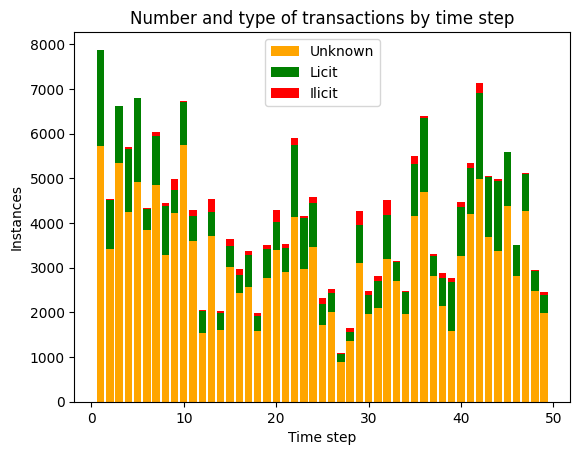

In [6]:
group_class_feature = df_class_feature.groupby(['Time Step', 'class']).count()
group_class_feature = group_class_feature['txId'].reset_index().rename(columns={'txId': 'count'})#unstack()

class1 = group_class_feature[group_class_feature['class'] == '1']
class2 = group_class_feature[group_class_feature['class'] == '2']
class3 = group_class_feature[group_class_feature['class'] == '3']

p1 = plt.bar(class3['Time Step'], class3['count'], color = 'orange')

p2 = plt.bar(class2['Time Step'], class2['count'], color='g',
             bottom=class3['count'])

p3 = plt.bar(class1['Time Step'], class1['count'], color='r',
             bottom=np.array(class3['count'])+np.array(class2['count']))

plt.title('Number and type of transactions by time step')
plt.xlabel('Time step')
plt.ylabel('Instances')
plt.legend(['Unknown', 'Licit', 'Ilicit'])
plt.show()

### Splitting data

In [7]:
# Count the amount of illicit nodes of each time step
ilicit_count = []

for i in range(1,50):
    temp = df_class_feature[df_class_feature['Time Step'] == i].groupby('class').count()
    temp = temp['txId'].reset_index().rename(columns={'txId': 'count'})#unstack()
    ilicit_count.append([i, temp[temp['class'] == '1']['count'][0]])

ilicit_count.sort(key = lambda row: row[1], reverse=True)


In [8]:
TEST_SIZE = 0.2
test_length = 0
i_group = 0
assigned_train = []
assigned_test = []
test_df = pd.DataFrame()
train_df = pd.DataFrame()

while test_length < (df_class_feature.shape[0] * TEST_SIZE):
    if len(assigned_test) == len(assigned_train):
        assigned_test.append(ilicit_count[i_group][0])
        test_df = pd.concat([test_df, df_class_feature[:][df_class_feature['Time Step'] == ilicit_count[i_group][0]]], ignore_index=True)
        test_length+=df_class_feature[df_class_feature['Time Step'] == ilicit_count[i_group][0]].shape[0]
        i_group+=1
    
    else:
        train_df = pd.concat([train_df, df_class_feature[:][df_class_feature['Time Step'] == ilicit_count[i_group][0]]], ignore_index=True)
        assigned_train.append(ilicit_count[i_group][0])        
        i_group+=1

while i_group < 49:
    train_df = pd.concat([train_df, df_class_feature[:][df_class_feature['Time Step'] == ilicit_count[i_group][0]]], ignore_index=True)
    assigned_train.append(ilicit_count[i_group][0])        
    i_group+=1    

### Visualizing split

In [9]:
train_df

,txId,class,Time Step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,...,Aggregate_feature_63,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72
0,10278231,3,29,0.268456,0.127770,1.573595,-0.121970,0.611176,-0.113002,-0.061584,...,1.538730,0.807542,0.190379,0.401797,-0.098889,0.335448,0.193816,-0.008915,-0.562507,-0.795034
1,163809013,2,29,-0.160498,4.081258,2.128587,5.956069,-0.063725,6.260528,-0.061584,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,102614111,3,29,-0.172910,-0.161607,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.479951,-0.493772,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399
3,168218829,3,29,2.206400,0.347772,1.573595,1.078631,-0.043875,-0.113002,4.807154,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,0.104754,0.333655,0.333211,-1.760926,-1.760984
4,163670715,3,29,-0.167215,-0.107012,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.300600,-0.380239,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160602,194379275,3,46,-0.172700,0.278765,1.573595,0.028105,-0.063725,-0.029140,0.242712,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
160603,194342019,3,46,-0.160442,0.162192,-0.091383,-0.046932,-0.043875,-0.113002,0.242712,...,-0.569626,-0.607306,-0.979074,-0.978556,-0.098889,-0.087490,-0.084674,-0.140597,-1.760926,-1.760984
160604,44587060,3,46,-0.172844,0.967734,0.463609,0.103143,-0.043875,-0.113002,0.851305,...,1.896446,1.486763,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
160605,195421155,3,46,-0.172788,0.521994,-0.091383,-0.046932,-0.043875,-0.029140,-0.061584,...,0.200087,0.042360,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399


In [10]:
test_df

,txId,class,Time Step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,...,Aggregate_feature_63,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72
0,355126269,3,32,-0.165383,-0.152052,-0.091383,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.569626,-0.607306,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,355006838,2,32,-0.172963,-0.055657,0.463609,-0.046932,-0.043875,-0.029140,-0.061584,...,-0.502370,-0.550539,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,246132693,2,32,-0.172977,0.461319,1.018602,0.703443,-0.043875,0.809483,-0.061584,...,0.087993,0.073897,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,355236739,2,32,-0.172951,0.501816,1.573595,0.628405,-0.063725,0.725620,-0.061584,...,-0.577099,1.366921,0.241128,0.241406,0.252616,-0.049041,-0.131155,0.074770,-0.120613,-0.119792
4,355006978,3,32,-0.172678,-0.116952,0.463609,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.360384,-0.430698,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43157,85050217,3,26,-0.149708,-0.172527,0.463609,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.562153,-0.600999,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
43158,84359523,3,26,-0.172901,-0.127651,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.465005,-0.519002,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,-1.760926,-1.760984
43159,84756090,3,26,-0.171273,-0.138139,1.018602,-0.046932,-0.043875,-0.029140,-0.061584,...,2.195364,2.395034,-0.979074,-0.978556,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399
43160,85270257,3,26,-0.164015,-0.081127,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,2.001068,1.562452,-0.979074,-0.978556,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399


In [11]:
print(assigned_train)

[29, 20, 42, 22, 24, 16, 41, 38, 7, 17, 28, 30, 39, 19, 8, 49, 23, 18, 14, 37, 34, 48, 36, 4, 27, 43, 44, 33, 47, 2, 10, 1, 12, 3, 5, 6, 45, 46]


In [12]:
train_df['Time Step'].unique()

array([29, 20, 42, 22, 24, 16, 41, 38,  7, 17, 28, 30, 39, 19,  8, 49, 23,
       18, 14, 37, 34, 48, 36,  4, 27, 43, 44, 33, 47,  2, 10,  1, 12,  3,
        5,  6, 45, 46], dtype=int64)

In [13]:
print(assigned_test)

[32, 13, 9, 35, 15, 11, 25, 40, 31, 21, 26]


In [14]:
test_df['Time Step'].unique()

array([32, 13,  9, 35, 15, 11, 25, 40, 31, 21, 26], dtype=int64)

We can see that both datasets contain a different set of subgraphs and that have an acceptable balance of licit and ilicit nodes

In [15]:
temp = train_df.groupby('class').count()
temp = temp['txId'].reset_index().rename(columns={'txId': 'count'})#unstack()
temp.head()

,class,count
0,1,2672
1,2,34654
2,3,123281


In [16]:
temp = test_df.groupby('class').count()
temp = temp['txId'].reset_index().rename(columns={'txId': 'count'})#unstack()
temp.head()

,class,count
0,1,1873
1,2,7365
2,3,33924


### Saving results

#### Saving and loading dataframes

In [17]:
# Save files
path = "dades/"
train_df.to_csv(path + 'train_set.csv', index=False)
test_df.to_csv(path + 'test_set.csv', index=False)

In [22]:
# Read files
path = ""
train_df = pd.read_csv(path + "train_set.csv") 
test_df = pd.read_csv(path + "test_set.csv")

#### Graph creation, saving and loading

In [23]:
generate_graph = True

if generate_graph:
    # Create an empty graph
    G_train = nx.Graph()
    G_test = nx.Graph()
    trainsactions = train_df['txId'].unique()    

    for _, row in train_df.iterrows():
        # Extract node ID and attributes
        node_id = row['txId']
        node_attributes = row.drop('txId').to_dict()
        # Add node to the graph with its attributes
        G_train.add_node(node_id, **node_attributes)
    
    for _, row in test_df.iterrows():
        # Extract node ID and attributes
        node_id = row['txId']
        node_attributes = row.drop('txId').to_dict()
        # Add node to the graph with its attributes
        G_test.add_node(node_id, **node_attributes)

    # Add edges to the graph
    for _, row in df_edges.iterrows():
        if row['txId1'] in trainsactions:
            G_train.add_edge(row['txId1'], row['txId2'])
        else:
            G_test.add_edge(row['txId1'], row['txId2'])
    
    # Save the graph as a pickle file
    with open("TrainSet_Grpah.pkl", "wb") as f:
        pkl.dump(G_train, f)
    with open("TestSet_Grpah.pkl", "wb") as f:
        pkl.dump(G_test, f)

In [24]:
# Specify the path to your pickle file
pickle_train_path = "TrainSet_Grpah.pkl"
pickle_test_path = "TestSet_Grpah.pkl"
# Open the pickle file in binary mode
with open(pickle_train_path, 'rb') as f:
    # Load the data from the pickle file
    G_train = pkl.load(f)
with open(pickle_test_path, 'rb') as f:
    # Load the data from the pickle file
    G_test = pkl.load(f)